# Import requirements

In [3]:
import sys
sys.path.append("../src")
import os
from scipy.io import loadmat
import torch
import numpy as np
from plotUtils import plotTrueAndEstimatedLatents
from kernels import PeriodicKernel, ExponentialQuadraticKernel
import svGPFAModelFactory
from svEM import SVEM

# Load data and initial values

In [7]:
yNonStackedFilename = os.path.expanduser("data/YNonStacked.mat")
dataFilename = os.path.expanduser("data/demo_PointProcess.mat")

mat = loadmat(yNonStackedFilename)
YNonStacked = mat['YNonStacked']

mat = loadmat(dataFilename)
nLatents = len(mat['Z0'])
nTrials = mat['Z0'][0,0].shape[2]
qMu0 = [torch.from_numpy(mat['q_mu0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSVec0 = [torch.from_numpy(mat['q_sqrt0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
qSDiag0 = [torch.from_numpy(mat['q_diag0'][(0,i)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
Z0 = [torch.from_numpy(mat['Z0'][(i,0)]).type(torch.DoubleTensor).permute(2,0,1) for i in range(nLatents)]
C0 = torch.from_numpy(mat["C0"]).type(torch.DoubleTensor)
b0 = torch.from_numpy(mat["b0"]).type(torch.DoubleTensor).squeeze()
legQuadPoints = torch.from_numpy(mat['ttQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
legQuadWeights = torch.from_numpy(mat['wwQuad']).type(torch.DoubleTensor).permute(2, 0, 1)
kernelNames = mat["kernelNames"]
hprs0 = mat["hprs0"]
testTimes = torch.from_numpy(mat['testTimes']).type(torch.DoubleTensor).squeeze()
trueLatents = [[torch.from_numpy(mat['trueLatents'][tr,k]).type(torch.DoubleTensor) 
                for tr in range(nTrials)] for k in range(nLatents)]

# Create kernels

In [8]:
kernels = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernels[k] = PeriodicKernel(scale=1.0)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernels[k] = ExponentialQuadraticKernel(scale=1.0)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))

# Set parameters

In [22]:
kernelsParams0 = [[None] for k in range(nLatents)]
for k in range(nLatents):
    if np.char.equal(kernelNames[0,k][0], "PeriodicKernel"):
        kernelsParams0[k] = torch.tensor([float(hprs0[k,0][0]),
                                          float(hprs0[k,0][1])],
                                         dtype=torch.double)
    elif np.char.equal(kernelNames[0,k][0], "rbfKernel"):
        kernelsParams0[k] = torch.tensor([float(hprs0[k,0][0])],
                                         dtype=torch.double)
    else:
        raise ValueError("Invalid kernel name: %s"%(kernelNames[k]))
qUParams0 = {"qMu0": qMu0, "qSVec0": qSVec0, "qSDiag0": qSDiag0}
qHParams0 = {"C0": C0, "d0": b0}
kmsParams0 = {"kernelsParams0": kernelsParams0,
              "inducingPointsLocs0": Z0}
initialParams = {"svPosteriorOnIndPoints": qUParams0,
                 "kernelsMatricesStore": kmsParams0,
                 "svEmbedding": qHParams0}
quadParams = {"legQuadPoints": legQuadPoints,
              "legQuadWeights": legQuadWeights}
optimParams = {"emMaxNIter":20, 
               "eStepMaxNIter":100, 
               "mStepModelParamsMaxNIter":100, 
               "mStepKernelParamsMaxNIter":100, 
               "mStepKernelParamsLR":1e-5, 
               "mStepIndPointsMaxNIter":100}        

# Create model

In [23]:
    model = svGPFAModelFactory.SVGPFAModelFactory.buildModel(
        conditionalDist=svGPFAModelFactory.PointProcess,
        linkFunction=svGPFAModelFactory.ExponentialLink,
        embeddingType=svGPFAModelFactory.LinearEmbedding)

# Maximize the Lower Bound
<span style="color:red">(Warning: with the parameters above, this step takes around 15 minutes)</span>

In [24]:
svEM = SVEM()
maxRes = svEM.maximize(model=model, measurements=YNonStacked,
                       kernels=kernels, initialParams=initialParams,
                       quadParams=quadParams, optimParams=optimParams)


Iteration 00, E-Step start
Iteration: 0, negative lower bound: 5446.934373
Iteration: 10, negative lower bound: 5353.726532
Iteration: 20, negative lower bound: 5329.918221
Iteration: 30, negative lower bound: 5311.900106
Iteration: 40, negative lower bound: 5297.161992
Iteration: 50, negative lower bound: 5284.726023
Iteration: 60, negative lower bound: 5273.688403
Iteration: 70, negative lower bound: 5263.817440
Iteration: 80, negative lower bound: 5254.823351
Iteration: 90, negative lower bound: 5246.572574
Iteration 00, E-Step end: 5239.682599
Iteration 00, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4991.605834
Iteration: 10, negative sum of expected log likelihood: 4981.298035
Iteration: 20, negative sum of expected log likelihood: 4971.643072
Iteration: 30, negative sum of expected log likelihood: 4962.592806
Iteration: 40, negative sum of expected log likelihood: 4954.104206
Iteration: 50, negative sum of expected log likelihood: 4946.141164

Iteration: 30, negative sum of expected log likelihood: 4689.825106
Iteration: 40, negative sum of expected log likelihood: 4688.084854
Iteration: 50, negative sum of expected log likelihood: 4686.552420
Iteration: 60, negative sum of expected log likelihood: 4685.182790
Iteration: 70, negative sum of expected log likelihood: 4683.950955
Iteration: 80, negative sum of expected log likelihood: 4682.839234
Iteration: 90, negative sum of expected log likelihood: 4681.831968
Iteration 03, M-Step Model Params end: 4681.003592
Iteration 03, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4876.137221
Iteration: 10, negative lower bound: 4876.150195
Iteration: 20, negative lower bound: 4876.084863
Iteration: 30, negative lower bound: 4876.046968
Iteration: 40, negative lower bound: 4876.024501
Iteration: 50, negative lower bound: 4876.002851
Iteration: 60, negative lower bound: 4875.981234
Iteration: 70, negative lower bound: 4875.960032
Iteration: 80, negative lower bound: 4875

Iteration: 40, negative lower bound: 4791.876689
Iteration: 50, negative lower bound: 4791.859714
Iteration: 60, negative lower bound: 4791.843193
Iteration: 70, negative lower bound: 4791.826882
Iteration: 80, negative lower bound: 4791.810774
Iteration: 90, negative lower bound: 4791.794708
Iteration 06, M-Step Kernel Params end: 4791.780270
Iteration 06, M-Step Ind Points start
Iteration: 0, negative lower bound: 4791.778664
Iteration: 10, negative lower bound: 4829.734055
Iteration: 20, negative lower bound: 4798.254577
Iteration: 30, negative lower bound: 4797.513295
Iteration: 40, negative lower bound: 4794.259386
Iteration: 50, negative lower bound: 4792.545724
Iteration: 60, negative lower bound: 4791.087106
Iteration: 70, negative lower bound: 4790.407851
Iteration: 80, negative lower bound: 4789.798320
Iteration: 90, negative lower bound: 4789.424622
Iteration 06, M-Step Ind Points end: 4789.197791
Iteration 07, E-Step start
Iteration: 0, negative lower bound: 4789.174539
Ite

Iteration: 80, negative lower bound: 4754.546252
Iteration: 90, negative lower bound: 4753.929966
Iteration 09, M-Step Ind Points end: 4753.555904
Iteration 10, E-Step start
Iteration: 0, negative lower bound: 4753.520767
Iteration: 10, negative lower bound: 4753.664018
Iteration: 20, negative lower bound: 4751.934490
Iteration: 30, negative lower bound: 4751.018546
Iteration: 40, negative lower bound: 4750.443302
Iteration: 50, negative lower bound: 4749.929361
Iteration: 60, negative lower bound: 4749.452393
Iteration: 70, negative lower bound: 4749.000418
Iteration: 80, negative lower bound: 4748.567394
Iteration: 90, negative lower bound: 4748.151639
Iteration 10, E-Step end: 4747.792396
Iteration 10, M-Step Model Params start
Iteration: 0, negative sum of expected log likelihood: 4573.037190
Iteration: 10, negative sum of expected log likelihood: 4572.670475
Iteration: 20, negative sum of expected log likelihood: 4572.622546
Iteration: 30, negative sum of expected log likelihood: 

Iteration: 10, negative sum of expected log likelihood: 4560.014628
Iteration: 20, negative sum of expected log likelihood: 4559.995121
Iteration: 30, negative sum of expected log likelihood: 4559.986669
Iteration: 40, negative sum of expected log likelihood: 4559.984790
Iteration: 50, negative sum of expected log likelihood: 4559.984140
Iteration: 60, negative sum of expected log likelihood: 4559.983773
Iteration: 70, negative sum of expected log likelihood: 4559.983651
Iteration: 80, negative sum of expected log likelihood: 4559.983615
Iteration: 90, negative sum of expected log likelihood: 4559.983599
Iteration 13, M-Step Model Params end: 4559.983595
Iteration 13, M-Step Kernel Params start
Iteration: 0, negative lower bound: 4730.331077
Iteration: 10, negative lower bound: 4730.694430
Iteration: 20, negative lower bound: 4730.395785
Iteration: 30, negative lower bound: 4730.302576
Iteration: 40, negative lower bound: 4730.289279
Iteration: 50, negative lower bound: 4730.276181
Ite

Iteration: 10, negative lower bound: 4720.376856
Iteration: 20, negative lower bound: 4719.984806
Iteration: 30, negative lower bound: 4719.885539
Iteration: 40, negative lower bound: 4719.876977
Iteration: 50, negative lower bound: 4719.863228
Iteration: 60, negative lower bound: 4719.851303
Iteration: 70, negative lower bound: 4719.842404
Iteration: 80, negative lower bound: 4719.834429
Iteration: 90, negative lower bound: 4719.826822
Iteration 16, M-Step Kernel Params end: 4719.819933
Iteration 16, M-Step Ind Points start
Iteration: 0, negative lower bound: 4719.819165
Iteration: 10, negative lower bound: 4775.871161
Iteration: 20, negative lower bound: 4736.198728
Iteration: 30, negative lower bound: 4727.909101
Iteration: 40, negative lower bound: 4725.835883
Iteration: 50, negative lower bound: 4723.181596
Iteration: 60, negative lower bound: 4721.936977
Iteration: 70, negative lower bound: 4720.875209
Iteration: 80, negative lower bound: 4719.999882
Iteration: 90, negative lower

Iteration: 50, negative lower bound: 4718.193933
Iteration: 60, negative lower bound: 4716.523234
Iteration: 70, negative lower bound: 4715.178213
Iteration: 80, negative lower bound: 4713.969309
Iteration: 90, negative lower bound: 4713.129394
Iteration 19, M-Step Ind Points end: 4712.789403


# Predict latents at new times

In [25]:
muK, varK = model.predictLatents(newTimes=testTimes)

# Plot latents estimates for one trial

<IPython.core.display.Javascript object>


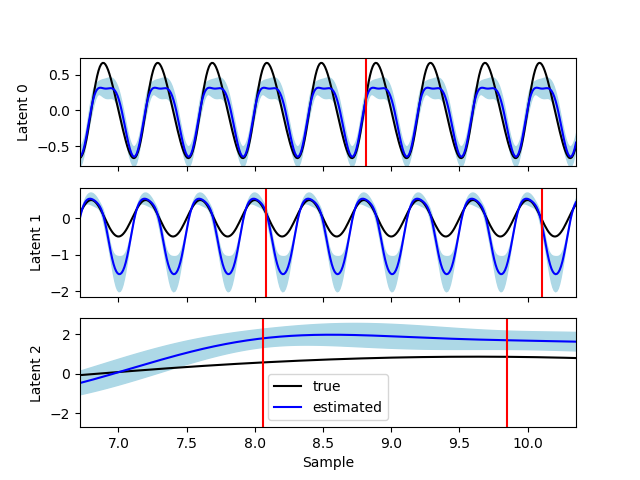

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [32]:
%matplotlib notebook
trialToPlot=0
nLatents = muK.shape[2]
timesToPlot = testTimes.numpy()
f, axes = plt.subplots(nLatents, 1, sharex=True)
for k in range(nLatents):
    trueLatentToPlot = trueLatents[k][trialToPlot].numpy().squeeze()
    muKToPlot = muK[trialToPlot,:,k].detach().numpy()
    errorToPlot = varK[trialToPlot,:,k].sqrt().detach().numpy()
    axes[k].plot(timesToPlot, trueLatentToPlot, label="true", color="black")
    axes[k].plot(timesToPlot, muKToPlot, label="estimated", color="blue")
    axes[k].fill_between(timesToPlot, muKToPlot-errorToPlot,
                          muKToPlot+errorToPlot, color="lightblue")
    for i in range(indPointsLocs[k].shape[1]):
        axes[k].axvline(x=indPointsLocs[k][trialToPlot,i, 0], color="red")
        axes[k].set_ylabel("Latent %d"%(k))
    axes[-1].set_xlabel("Sample")
    axes[-1].legend()
    plt.xlim(left=np.min(timesToPlot)-1, right=np.max(timesToPlot)+1)
    plt.show()